In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as npimg 
import numpy as np
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2

In [36]:
def YellowAndWhite(hsv_image): #Done
    masks = []
    low_white,high_white = np.array([0, 0, 200]),np.array([180, 25, 255])
    low_yellow,high_yellow = np.array([15, 40, 205]),np.array([25, 255, 255])
    white = cv2.inRange(hsv_image, low_white, high_white)
    masks.append(white)
    yellow = cv2.inRange(hsv_image, low_yellow, high_yellow)
    masks.append(yellow)
    return cv2.add(*masks)

In [37]:
def Force3D(mask, image): #Done
    masked_image = np.zeros_like(image)
    for i in range(3): 
        masked_image[:,:,i] = mask.copy()
    return masked_image

In [38]:
def RegionOfInterest(image, points): #Done
    mask = np.zeros_like(image)   
    ignore_color = 255

    cv2.fillPoly(mask, [points],ignore_color)
    masked_image = cv2.bitwise_and(image, mask)
    
    return masked_image

In [39]:
def FofY(y,mxb):
    return (y-mxb[1])/mxb[0] #Solve for X not Y

In [40]:
def ProcessImage(image):
    
    width,height = len(image[0]),len(image)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    color_mask = YellowAndWhite(hsv_image)

    masked_image = Force3D(color_mask, image) 

    edge_mask = cv2.Canny(masked_image, 50, 150) #check if you even need this. The mask may be good enough or better
      
    edged_image = Force3D(edge_mask, image) 
    
    p1,p2,p3,p4  = [10,height-10],[int(29/60*width),int(9/16*height)],[int(31/60*width),int(9/16*height)],[width-10,height-10]
    points = np.array([p1,p2,p3,p4], dtype=np.int32) 
    region_image= RegionOfInterest(edged_image, points) 
    
    grey_image = cv2.cvtColor(region_image, cv2.COLOR_RGB2GRAY)
    
    return grey_image

In [41]:
def ImageToLines(image): 
    rho = 1
    theta = np.pi/180
    threshold = 25
    min_line_length = 20
    max_line_gap = 15
    
    return cv2.HoughLinesP(image, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)
    

In [42]:
global left_lane_line, right_lane_line
left_lane_line, right_lane_line = [],[]

def LaneLineDetector(original_image):
    
    image = np.copy(original_image)
    width,height = len(image[0]),len(image)
    
    processed_image = ProcessImage(image)

    lines = ImageToLines(processed_image)
    
    global left_lane_line, right_lane_line
    lined_image = np.zeros_like(image) 
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1>width/2 and x2>width/2:
                if (y2-y1)/(x2-x1) > 0.4: 
                    cv2.line(lined_image, (x1, y1), (x2, y2), [255,0,0], 3)
                    right_lane_line.append([x1,y1])
                    right_lane_line.append([x2,y2])
            elif x1<width/2 and x2<width/2:
                if (y2-y1)/(x2-x1) < -0.4: 
                    cv2.line(lined_image, (x1, y1), (x2, y2), [255,0,0], 3)
                    left_lane_line.append([x1,y1])
                    left_lane_line.append([x2,y2])        
    
    while len(left_lane_line)> 100:
        left_lane_line.pop(0)
        
    while len(right_lane_line)> 100:
        right_lane_line.pop(0)
    
    leftx,lefty = [point[0] for point in left_lane_line],[point[1] for point in left_lane_line]
    leftmxb = np.polyfit(leftx,lefty,1)
    
    rightx,righty = [point[0] for point in right_lane_line],[point[1] for point in right_lane_line]
    rightmxb = np.polyfit(rightx,righty,1)
    
    fl = np.poly1d(leftmxb)
    fr = np.poly1d(rightmxb)
    
        
    lx1,lx2,rx1,rx2 = int(min(leftx)),int(FofY(height/1.65,leftmxb)),int(FofY(height/1.65,rightmxb)),int(max(rightx))
    ly1,ly2,ry1,ry2 = int(fl(lx1)),int(fl(lx2)),int(fr(rx1)),int(fr(rx2))
    
    cv2.line(lined_image, (lx1,ly1), (lx2, ly2), [0,0,255], 5) 
    cv2.line(lined_image, (rx1,ry1), (rx2, ry2), [0,0,255], 5)
    

    laned_image = cv2.addWeighted(original_image, 0.8, lined_image, 1, 0) 

    return laned_image 

# Tests

## Images and pipeline

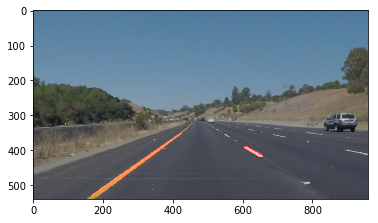

True

In [44]:
image = npimg.imread('TestImages/solidYellowCurve.jpg')
plt.imshow(LaneLineDetector(image))
plt.show()
cv2.imwrite('bluelanes.jpg',LaneLineDetector(image))

## Challenge video

In [45]:
final_clip_output = 'challenge1.mp4'
clip = VideoFileClip("TestVideos/challenge.mp4")
final_clip = clip.fl_image(LaneLineDetector)
%time final_clip.write_videofile(final_clip_output, audio=False)

[MoviePy] >>>> Building video challenge1.mp4
[MoviePy] Writing video challenge1.mp4


100%|██████████| 251/251 [00:34<00:00,  7.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge1.mp4 

CPU times: user 1min 37s, sys: 7.12 s, total: 1min 44s
Wall time: 36 s


In [8]:
HTML("""
<video width="960" height="520" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(final_clip_output))

## White line video

In [9]:
white_clip_output = 'solidWhiteRight.mp4'
clip1 = VideoFileClip("TestVideos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(LaneLineDetector)
%time white_clip.write_videofile(white_clip_output, audio=False)

[MoviePy] >>>> Building video solidWhiteRight11.mp4
[MoviePy] Writing video solidWhiteRight11.mp4


100%|█████████▉| 221/222 [00:16<00:00, 13.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solidWhiteRight11.mp4 

CPU times: user 47.7 s, sys: 3.57 s, total: 51.3 s
Wall time: 17.4 s


In [10]:
HTML("""
<video width="960" height="520" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(white_clip_output))

## Yellow line video

In [11]:
yellow_clip_output = 'solidYellowLeft.mp4'
clip2 = VideoFileClip("TestVideos/solidYellowLeft.mp4")
yellow_clip = clip2.fl_image(LaneLineDetector)
%time yellow_clip.write_videofile(yellow_clip_output, audio=False)

[MoviePy] >>>> Building video solidYellowLeft.mp4
[MoviePy] Writing video solidYellowLeft.mp4


100%|█████████▉| 681/682 [01:01<00:00, 12.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solidYellowLeft.mp4 

CPU times: user 2min 42s, sys: 11.4 s, total: 2min 53s
Wall time: 1min 2s


In [12]:
HTML("""
<video width="960" height="520" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(yellow_clip_output))